### Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import cv2
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.math import confusion_matrix
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten,Input,Dropout,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Data Import

In [ ]:
ds = pd.read_csv('labels.csv')
ds.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Data Analyse

In [ ]:
ds.shape

(10222, 2)

In [ ]:
ds["breed"].nunique()

120

In [ ]:
ds["breed"].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [ ]:
ds.isna().sum()

id       0
breed    0
dtype: int64

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [ ]:
df = ds.copy()

In [ ]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


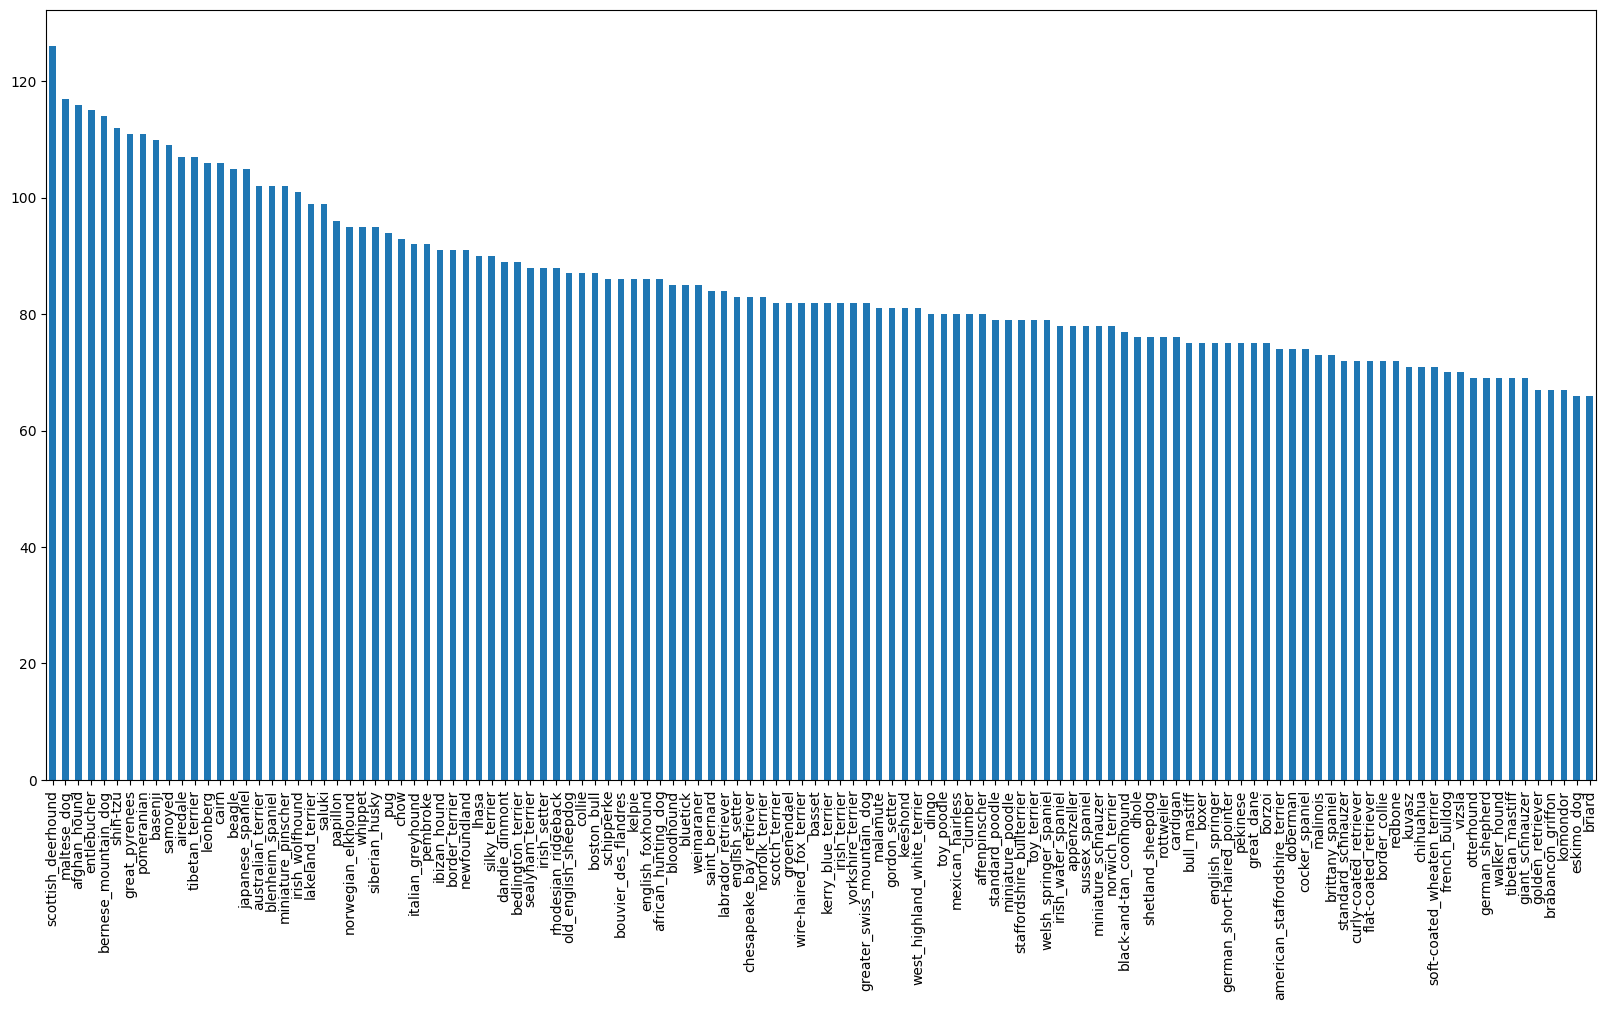

In [ ]:
breed_counts = df['breed'].value_counts()
breed_counts.plot.bar(figsize=(20, 10));

In [ ]:
included_breeds = breed_counts[breed_counts > 100].index.tolist()
df = df[df['breed'].isin(included_breeds)].reset_index(drop=True)

In [ ]:
df.shape

(2184, 2)

### Image Prep

In [ ]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

In [ ]:
image_dir = '/content/drive/MyDrive/Global AI Hub/Deep_Learning_Bootcamp/train'

In [ ]:
df.head()

,id,breed
0,003df8b8a8b05244b1d920bb6cf451f9,basenji
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,00693b8bc2470375cc744a6391d397ec,maltese_dog
3,00bee065dcec471f26394855c5c2f3de,cairn
4,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier


In [ ]:
resized_images = []
for idx, filename in enumerate(df['id']):
    img_path = os.path.join(image_dir, filename + '.jpg')
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

### Display first 20 images

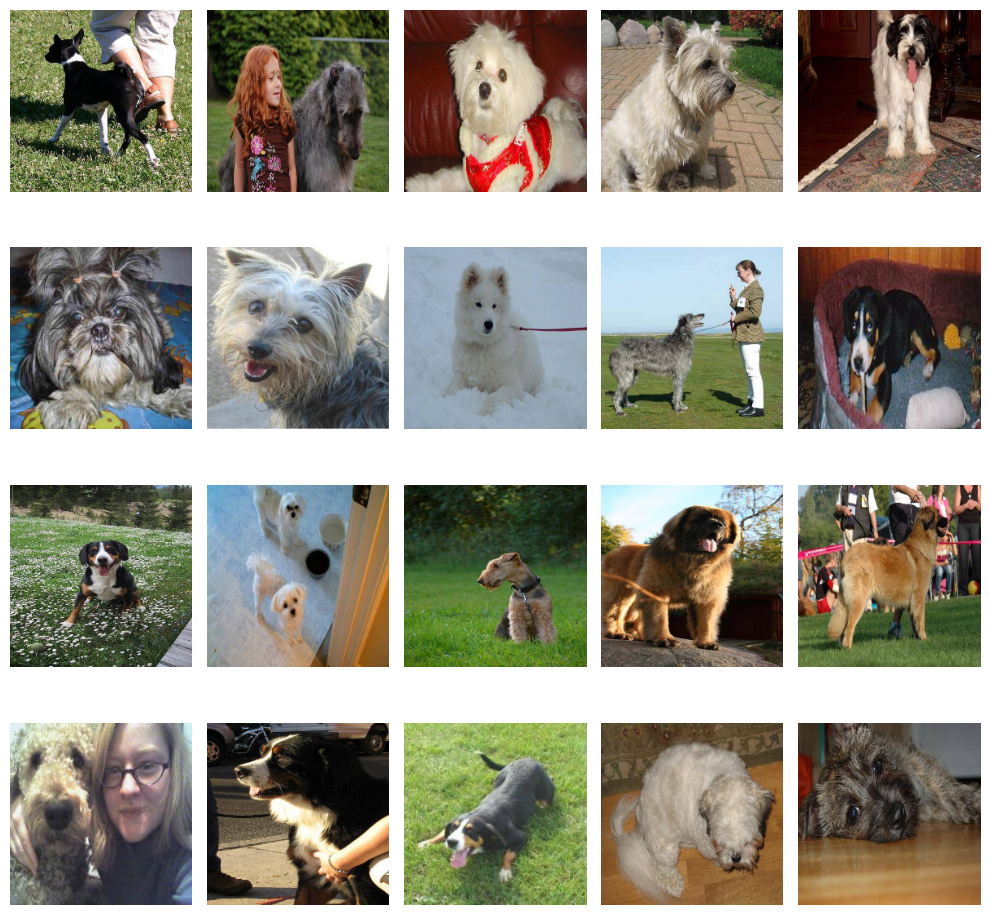

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(resized_images_array[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### Preprocess Labels

In [ ]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(resized_images_array, new_labels, test_size=0.20, random_state=28)
X_train.shape, X_test.shape

((1747, 224, 224, 3), (437, 224, 224, 3))

In [ ]:
X_train.shape

(1747, 224, 224, 3)

In [ ]:
X_test.shape

(437, 224, 224, 3)

In [ ]:
y_train.shape

(1747, 20)

In [ ]:
y_test.shape

(437, 20)

### Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

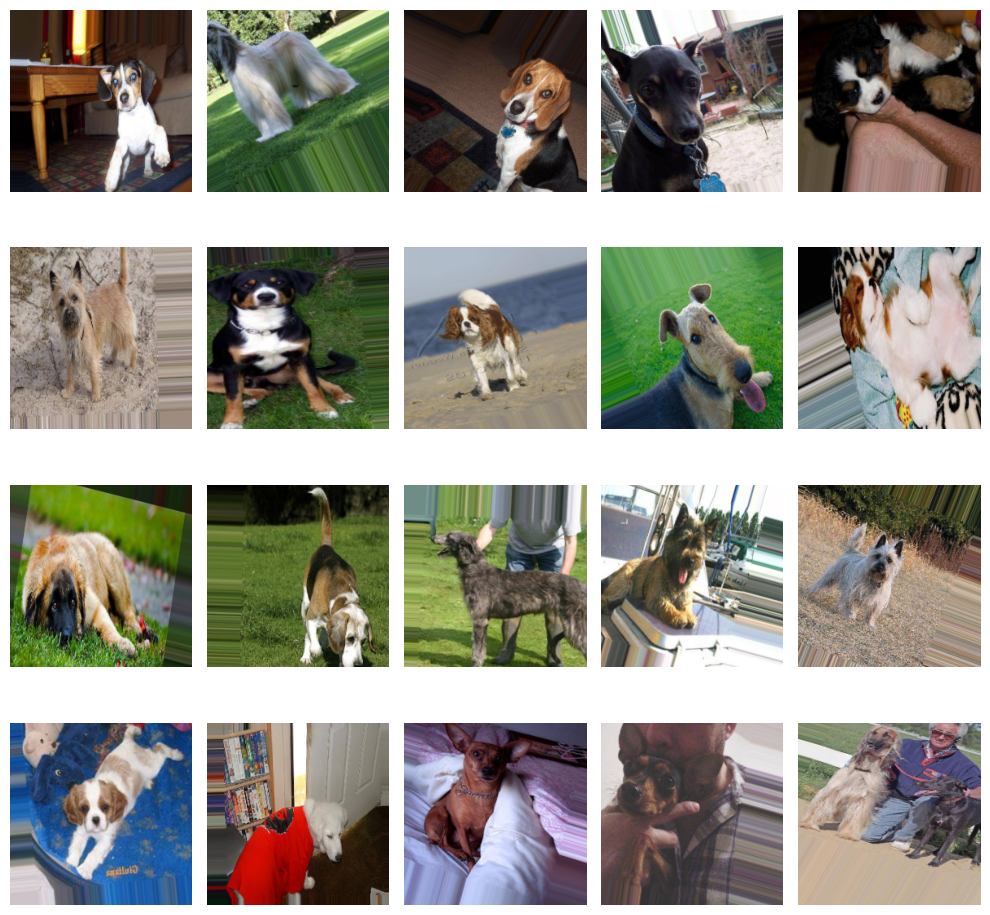

In [ ]:
augmented_images = train_datagen.flow(X_train, y=y_train, shuffle=True)
plt.figure(figsize=(10, 10))
for i in range(20):
    augmented_image = augmented_images.next()[0][0]
    plt.subplot(4, 5, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
bs = 64
training_set = train_datagen.flow(X_train, y_train, batch_size=bs)
testing_set = test_datagen.flow(X_test, y_test, batch_size=bs)

### Convolutional Neural Network

In [ ]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='sigmoid'),
    Dropout(0.2),
    Dense(20, activation='softmax')
])

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [ ]:
history=model.fit_generator(training_set, validation_data = testing_set, epochs = 10)

Epoch 1/10
55/55 [==============================] - 34s 380ms/step - loss: 3.0466 - accuracy: 0.0578 - val_loss: 3.0266 - val_accuracy: 0.0435
Epoch 2/10
55/55 [==============================] - 23s 421ms/step - loss: 2.9920 - accuracy: 0.0624 - val_loss: 2.9365 - val_accuracy: 0.0892
Epoch 3/10
55/55 [==============================] - 21s 387ms/step - loss: 2.8907 - accuracy: 0.1048 - val_loss: 2.8623 - val_accuracy: 0.0892
Epoch 4/10
55/55 [==============================] - 22s 393ms/step - loss: 2.8467 - accuracy: 0.1076 - val_loss: 2.8048 - val_accuracy: 0.1236
Epoch 5/10
55/55 [==============================] - 23s 416ms/step - loss: 2.8164 - accuracy: 0.1362 - val_loss: 2.7770 - val_accuracy: 0.1510
Epoch 6/10
55/55 [==============================] - 22s 398ms/step - loss: 2.7933 - accuracy: 0.1402 - val_loss: 2.7590 - val_accuracy: 0.1602
Epoch 7/10
55/55 [==============================] - 22s 397ms/step - loss: 2.7464 - accuracy: 0.1528 - val_loss: 2.7262 - val_accuracy: 0.1510

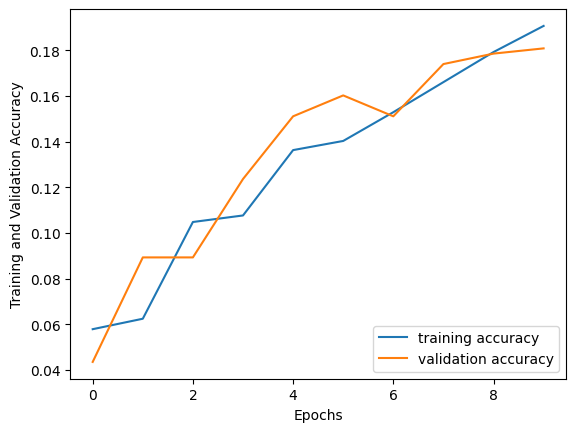

In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(loc='lower right')

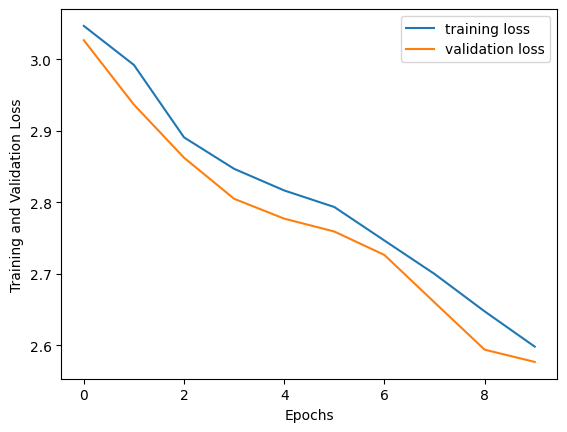

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()